<a href="https://colab.research.google.com/github/Ry02024/SignateCup2024Summer_Ry032/blob/master/notebooks/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習のPDCA：予測モデルの生成

ここではLightGBMモデルを構築し、予測を行います。まず、データを結合して前処理を行い、質的データにラベルエンコーディングを適用します。次に、トレーニングデータを訓練用と検証用に分割し、モデルを訓練。AUCスコアとROC曲線でモデルの性能を評価します。最後に、テストデータで予測を実行し、その結果を提出用ファイルとして保存します。これにより、一連の機械学習プロセスを効率的に完結させます。

## ライブラリの読み込み

本プロジェクトでは、データの前処理、機械学習モデルの作成、モデルの評価を行うために、必要なライブラリをインポートします。numpy や pandas などの基本的なデータ操作ライブラリに加え、LightGBM などの機械学習ライブラリや、モデル評価のためのメトリクスライブラリを使用しています。

In [1]:
# 必要なパッケージのインストール
!pip install japanize-matplotlib -q
!pip install catboost -q
!pip install category_encoders -q

# GitHubリポジトリのクローン
!git clone https://github.com/Ry02024/SignateCup2024Summer_Ry032.git

# 必要なライブラリのインポート
import japanize_matplotlib
import pandas as pd
import numpy as np
import re
import unicodedata
import datetime as dt
import matplotlib.pyplot as plt

# モデル関連ライブラリのインポート
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# カテゴリカルエンコーディングのためのライブラリ
from category_encoders import CatBoostEncoder

# クローンしたリポジトリ内のスクリプトをインポート
from SignateCup2024Summer_Ry032.src import preprocessing
from SignateCup2024Summer_Ry032.src import visualization
from SignateCup2024Summer_Ry032.src import model_optimization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00
Cloning into 'SignateCup2024Summer_Ry032'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 123 (delta 49), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 2.12 MiB | 5.37 MiB/s, done.
Resolving deltas: 100% (49/49), done.


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## データの読み込み

トレーニングデータとテストデータをGoogle Driveから読み込み、pandas データフレームとして保持します。トレーニングデータでは、学習に不要なカラム（id と ProdTaken）を削除し、特徴量とターゲットに分けます。テストデータでは、id カラムを削除して特徴量を取り出します。

In [2]:
%cd SignateCup2024Summer_Ry032/

/content/SignateCup2024Summer_Ry032


In [3]:
data_dir = "data/processed/basic/"
train_processed = pd.read_csv(data_dir + "train_processed.csv")
test_processed = pd.read_csv(data_dir + "test_processed.csv")

In [4]:
train_processed_x = train_processed.drop(['ProdTaken'], axis=1)
train_processed_y = train_processed['ProdTaken']

## モデルの生成

前処理が完了したデータを使用して、LightGBM モデルを作成します。まず、トレーニングデータをさらに訓練用と検証用に分割し、モデルの動作確認を行います。この段階では、クロスバリデーションやK-Foldは使用せず、単純にデータを分割してモデルを訓練します。モデルの性能を評価するために、検証データを使用してAUCスコアを算出し、ROC曲線をプロットしています。

### 評価関数の定義

In [5]:
import numpy as np

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    pt = np.where(y_true == 1, y_pred, 1 - y_pred)
    loss = -alpha * (1 - pt) ** gamma * np.log(pt)
    return loss

def focal_loss_lgb(y_pred, dtrain, alpha=0.25, gamma=2.0):
    y_true = dtrain.get_label()
    y_pred = 1.0 / (1.0 + np.exp(-y_pred))
    pt = np.where(y_true == 1, y_pred, 1 - y_pred)
    fl = focal_loss(y_true, y_pred, alpha, gamma)
    grad = alpha * y_pred * (1 - y_pred) * (gamma * (1 - pt) ** (gamma - 1) * np.log(pt) + (1 - pt) ** gamma / pt) * (2 * y_true - 1)
    hess = alpha * (1 - y_pred) * y_pred * (
        (1 - pt) ** (gamma - 2) * (
            (2 * gamma * (1 - pt) + gamma * (gamma - 1) * (1 - pt) + 1) * np.log(pt)
            + 2 * (1 - pt)
        ) - (1 - pt) ** gamma / pt ** 2
    ) * (2 * y_true - 1) ** 2
    return grad, hess

In [6]:
def weighted_cross_entropy(weight_positive=2.0):
    def weighted_cross_entropy_obj(y_pred, dtrain):
        y_true = dtrain.get_label()
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        grad = (y_pred - y_true) * (weight_positive * y_true + (1 - y_true))
        hess = y_pred * (1.0 - y_pred) * (weight_positive * y_true + (1 - y_true))
        return grad, hess
    return weighted_cross_entropy_obj

In [7]:
def dice_loss(smooth=1e-6):
    def dice_loss_obj(y_pred, dtrain):
        y_true = dtrain.get_label()
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        intersection = np.sum(y_true * y_pred)
        union = np.sum(y_true) + np.sum(y_pred)
        dice = (2.0 * intersection + smooth) / (union + smooth)
        grad = -2 * (y_true * (union - y_pred) - y_pred * (intersection + smooth)) / (union + smooth)**2
        hess = 2 * ((union - y_pred)**2 + y_pred * (intersection + smooth)) / (union + smooth)**3
        return grad, hess
    return dice_loss_obj

In [8]:
def balanced_cross_entropy():
    def balanced_cross_entropy_obj(y_pred, dtrain):
        y_true = dtrain.get_label()
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        pos_weight = np.sum(1 - y_true) / np.sum(y_true)
        grad = y_pred - y_true
        hess = y_pred * (1.0 - y_pred)
        grad *= np.where(y_true == 1, pos_weight, 1.0)
        hess *= np.where(y_true == 1, pos_weight, 1.0)
        return grad, hess
    return balanced_cross_entropy_obj

In [9]:
def asymmetric_loss(gamma_neg=4, gamma_pos=1):
    def asymmetric_loss_obj(y_pred, dtrain):
        y_true = dtrain.get_label()
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        pt = np.where(y_true == 1, y_pred, 1 - y_pred)
        grad = y_pred - y_true
        hess = y_pred * (1.0 - y_pred)
        grad *= np.where(y_true == 1, gamma_pos * (1 - pt)**(gamma_pos - 1), gamma_neg * pt**(gamma_neg - 1))
        hess *= np.where(y_true == 1, gamma_pos * (1 - pt)**(gamma_pos - 1), gamma_neg * pt**(gamma_neg - 1))
        return grad, hess
    return asymmetric_loss_obj

In [10]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
from sklearn.metrics import roc_auc_score, average_precision_score

def auc_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'auc', roc_auc_score(y_true, y_pred), True

def pr_auc_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'pr_auc', average_precision_score(y_true, y_pred), True

### 前処理

In [ ]:
# データフレーム内のカテゴリカルカラムを推定
categorical_columns = train_processed_x.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# ラベルエンコーディングの適用
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    train_processed_x[col] = le.fit_transform(train_processed_x[col].astype(str))
    test_processed[col] = le.transform(test_processed[col].astype(str))
    label_encoders[col] = le  # 将来的に必要な場合に備えてエンコーダーを保存

In [14]:
# トレーニングデータと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(train_processed_x, train_processed_y, test_size=0.2, random_state=42)

In [15]:
# LightGBM データセットを作成
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

### binary_logloss, auc, prauc

In [18]:
# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=100),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=500, verbose=True)
]
# モデルのパラメータ設定
params = {
    'objective': 'binary',
    'metric': 'none',  #['binary_logloss', 'auc'],  # AUCを計算するために'metric'に'auc'を追加
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'random_state': 42,
    'force_row_wise': True,  # オーバーヘッドを削減
    'scale_pos_weight':len(y_train) / (2 * np.sum(y_train)),  # 正例に対する負例を調整
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=10000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks=callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)

# AUCスコアの計算
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)

# PR-AUCスコアの計算
pr_auc_score = average_precision_score(y_valid, y_valid_pred_probs)

# 結果の表示
print(f"AUCスコア: {auc_score:.4f}")
print(f"PR-AUCスコア: {pr_auc_score:.4f}")


[LightGBM] [Info] Number of positive: 406, number of negative: 2385
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145468 -> initscore=-1.770601
[LightGBM] [Info] Start training from score -1.770601
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.929095	training's pr_auc: 0.69115	valid_1's auc: 0.849566	valid_1's pr_auc: 0.536965
[200]	training's auc: 0.952309	training's pr_auc: 0.758324	valid_1's auc: 0.852164	valid_1's pr_auc: 0.530576
[300]	training's auc: 0.968382	training's pr_auc: 0.819605	valid_1's auc: 0.857288	valid_1's pr_auc: 0.538998
[400]	training's auc: 0.979423	training's pr_auc: 0.874938	valid_1's auc: 0.857288	valid_1's pr_auc: 0.534672
[500]	training's auc: 0.987205	training's pr_auc: 0.916268	valid_1's auc: 0.857324	valid_1's pr_auc: 0.538903
[600]	training's auc: 0.991605	training's pr_auc: 0.942926	val

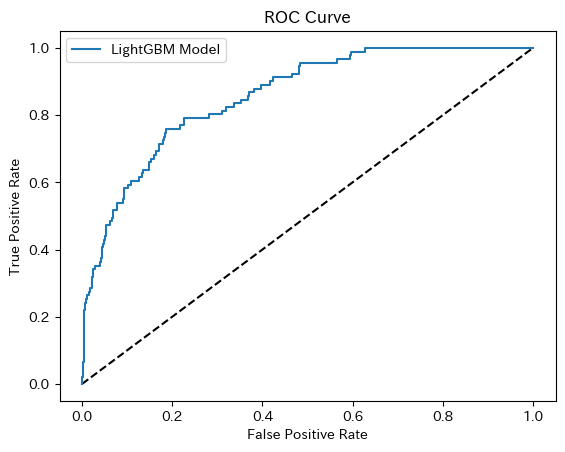

In [19]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

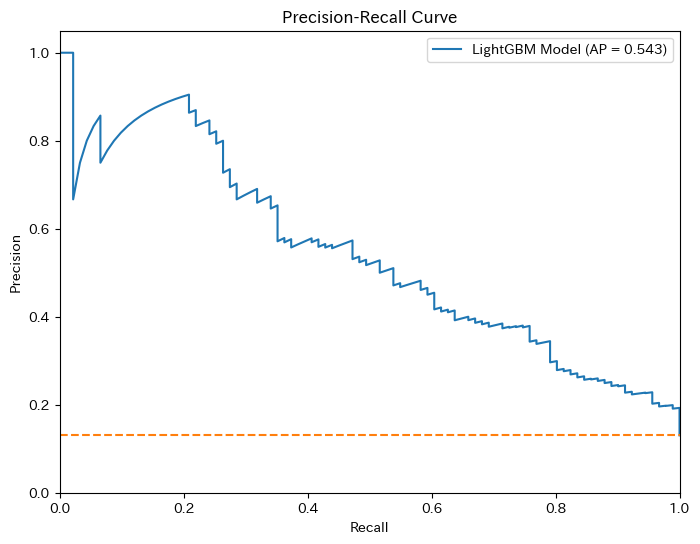

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### focal_loss, auc, pr_auc

In [21]:
# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': focal_loss_lgb,
    'metric': 'nonw',  # AUCを計算するために'metric'に'auc'を追加
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

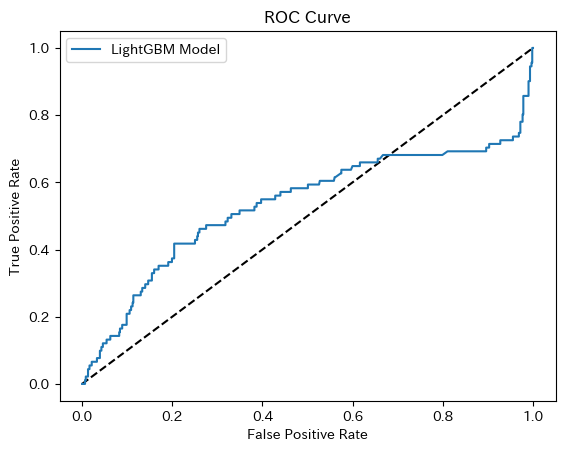

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

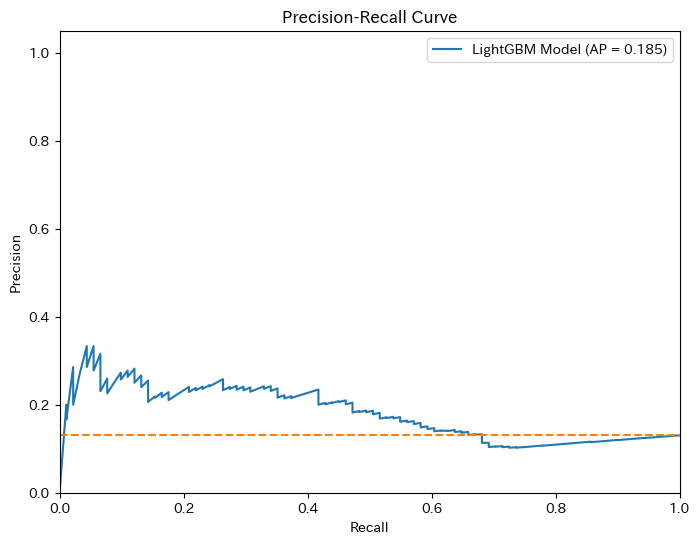

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### Weighted Cross-Entropy, auc, pr_auc

In [ ]:
# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': weighted_cross_entropy(weight_positive=2.0),
    'metric': 'nonw',  # AUCを計算するために'metric'に'auc'を追加
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.882651	training's pr_auc: 0.596429	valid_1's auc: 0.827353	valid_1's pr_auc: 0.481248
[20]	training's auc: 0.892945	training's pr_auc: 0.641591	valid_1's auc: 0.842171	valid_1's pr_auc: 0.528556
[30]	training's auc: 0.914679	training's pr_auc: 0.686922	valid_1's auc: 0.853766	valid_1's pr_auc: 0.5414
[40]	training's auc: 0.928907	training's pr_auc: 0.72323	valid_1's auc: 0.853232	valid_1's pr_auc: 0.538897
[50]	training's auc: 0.940341	training's p

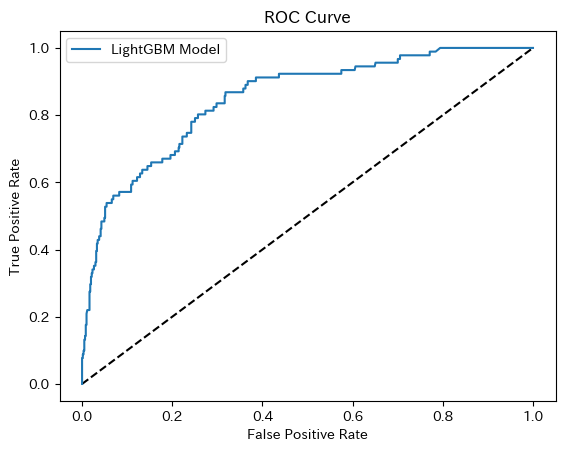

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

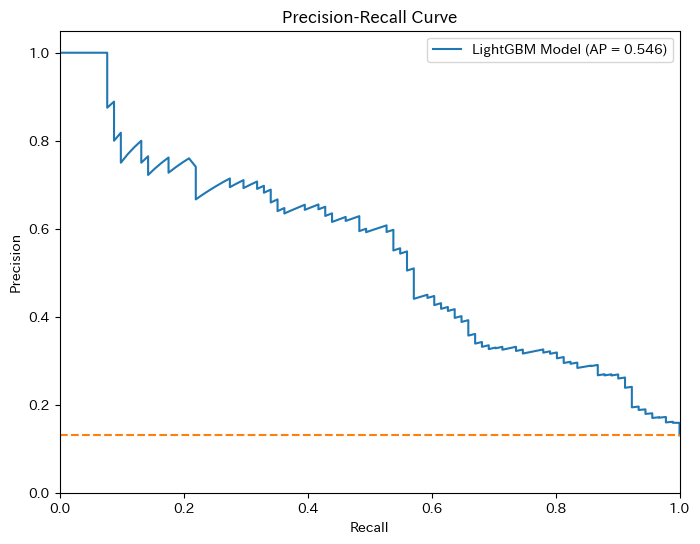

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### dice_loss, auc, pr_auc

In [ ]:
# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': dice_loss(smooth=1e-6),
    'metric': 'none',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.810313	training's pr_auc: 0.501508	valid_1's auc: 0.749308	valid_1's pr_auc: 0.34588
[20]	training's auc: 0.810563	training's pr_auc: 0.502587	valid_1's auc: 0.748873	valid_1's pr_auc: 0.346335
[30]	training's auc: 0.811108	training's pr_auc: 0.514883	valid_1's auc: 0.748773	valid_1's pr_auc: 0.346171
[40]	training's auc: 0.811819	training's pr_auc: 0.520536	valid_1's auc: 0.750629	valid_1's pr_auc: 0.352334
[50]	training's auc: 0.812199	training's

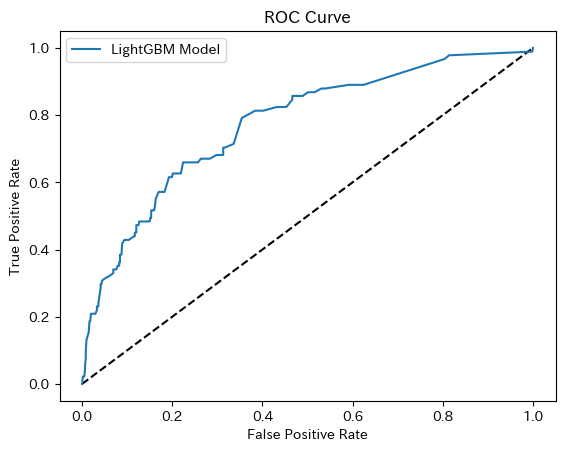

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

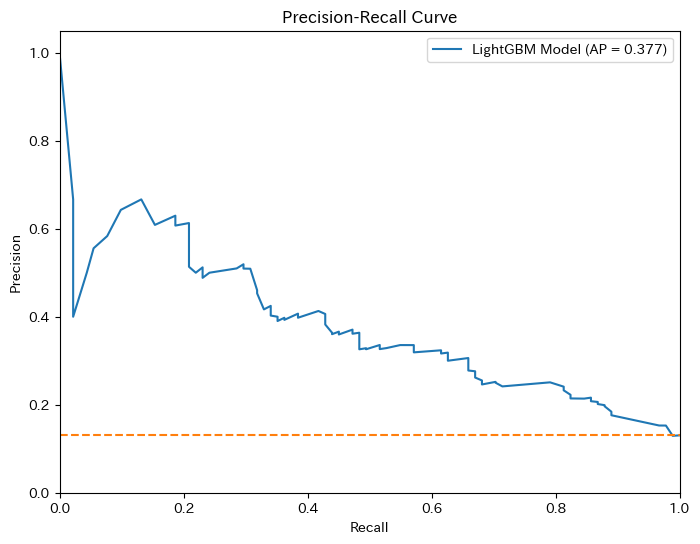

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### balanced_cross_entropy, auc, pr_auc

In [ ]:
# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': balanced_cross_entropy(),
    'metric': 'none',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.895157	training's pr_auc: 0.535261	valid_1's auc: 0.831191	valid_1's pr_auc: 0.476152
[20]	training's auc: 0.913921	training's pr_auc: 0.601258	valid_1's auc: 0.846697	valid_1's pr_auc: 0.553275
[30]	training's auc: 0.929108	training's pr_auc: 0.65585	valid_1's auc: 0.849585	valid_1's pr_auc: 0.560392
[40]	training's auc: 0.940036	training's pr_auc: 0.692526	valid_1's auc: 0.847177	valid_1's pr_auc: 0.549997
[50]	training's auc: 0.950688	training's pr_auc: 0.729748	valid_1's auc: 0.850988	valid_1's pr_auc: 0.55

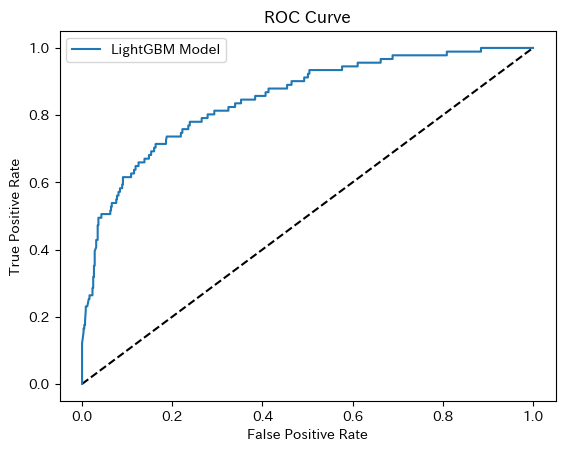

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

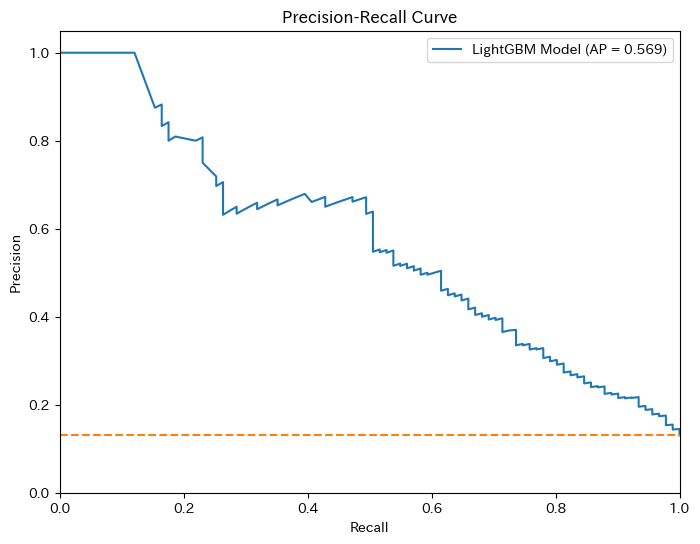

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### asymmetric_loss, auc, pr_auc

In [ ]:
# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=10),  # 100イテレーションごとに結果を表示
    early_stopping(stopping_rounds=100, verbose=True)
]

# モデルのパラメータ設定
params = {
    'objective': asymmetric_loss(gamma_neg=4, gamma_pos=1),
    'metric': 'none',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'random_state': 42,
}

# モデルの訓練とAUCの計算
lgb_model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, valid_dataset],
                      num_boost_round=1000,
                      feval=[auc_eval, pr_auc_eval],
                      callbacks = callbacks)

# 検証データでの予測
y_valid_pred_probs = lgb_model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_valid_pred_probs)
print(f"AUCスコア: {auc_score:.4f}")

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.857655	training's pr_auc: 0.540769	valid_1's auc: 0.825289	valid_1's pr_auc: 0.450317
[20]	training's auc: 0.869163	training's pr_auc: 0.567775	valid_1's auc: 0.819786	valid_1's pr_auc: 0.474555
[30]	training's auc: 0.880047	training's pr_auc: 0.579205	valid_1's auc: 0.823035	valid_1's pr_auc: 0.480096
[40]	training's auc: 0.883316	training's pr_auc: 0.581285	valid_1's auc: 0.823687	valid_1's pr_auc: 0.480766
[50]	training's auc: 0.892986	training'

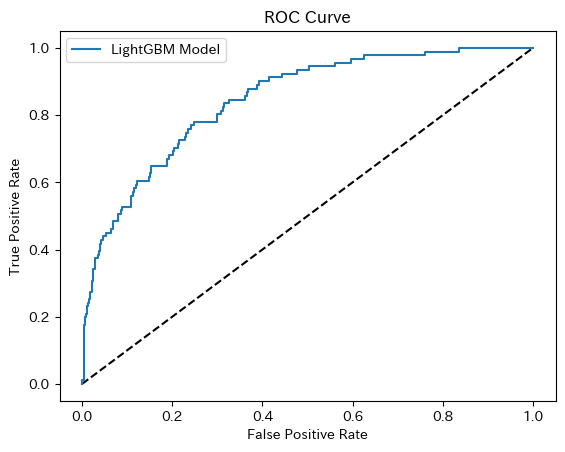

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC曲線のデータを取得
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_probs)

# ROC曲線のプロット
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LightGBM Model')  # ラベルを「LightGBM Model」に変更
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')  # 凡例を追加
plt.show()

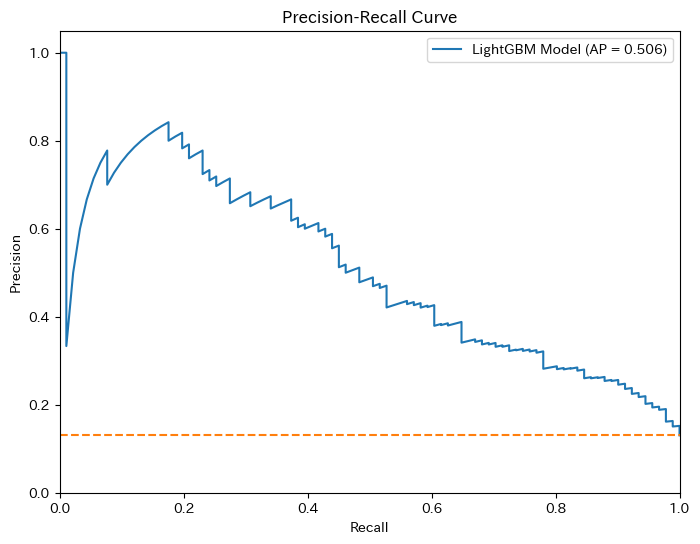

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR曲線のデータを取得
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_pred_probs)

# Average Precision Scoreを計算
ap_score = average_precision_score(y_valid, y_valid_pred_probs)

# PR曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LightGBM Model (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ランダム分類器のベースラインを追加
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()